In [1]:
import numpy as np

import qiskit.quantum_info as qi
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, Operator
from qiskit.visualization import plot_histogram
sim = AerSimulator()

from util import zero, one, measure_outcome, Pretty

# QI: Quantum Teleportation

In this notebook, we'll introduce **quantum teleportation**. It is a protocol that enables one party to send a qubit to another party using one shared entangled qubit and two classical bits. Importantly, this protocol does not violate no cloning.

References
1. [https://learn.qiskit.org/course/ch-algorithms/quantum-teleportation](https://learn.qiskit.org/course/ch-algorithms/quantum-teleportation)
2. [Introduction to Quantum Information Science: Lecture 10 by Scott Aaronson](https://www.scottaaronson.com/qclec.pdf)
3. [Quantum Computation and Quantum Information: Chapter 1.3, Nielsen and Chuang](https://www.cambridge.org/highereducation/books/quantum-computation-and-quantum-information/01E10196D0A682A6AEFFEA52D53BE9AE#overview)


## Problem

1. Two parties, one named Alice and another named Bob.
2. Question: Can Alice send a qubit to Bob? That is, after the end of sending her qubit, she no longer has access to it.
3. Answer: yes, but only if Alice and Bob share an entangled qubit and uses two classical bits.

In [2]:
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr_alice = QuantumRegister(2, name="q_Alice")
qr_bob = QuantumRegister(1, name="q_Bob")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr_alice, qr_bob, crz, crx)

### Step 1: Charlie creates entangled state

Suppose Alice wants to transmit 

$$
|\psi\rangle = \alpha|0\rangle + \beta|1\rangle \,.
$$

We will start with an initial quantum state

\begin{align*}
|psi_0\rangle & = |q_2 q_1 q_0\rangle \\
& = |00\rangle \otimes |\psi\rangle 
\end{align*}

Alice will own $q_0$ and $q_1$, Bob will own $q_2$, and Charlie will entangle qubits $q_1$ and $q_2$.

In [3]:
def create_bell_pair(qc, a, b):
    qc.h(a)     # Put qubit a into state |+>
    qc.cx(a, b) # CNOT with a as control and b as target

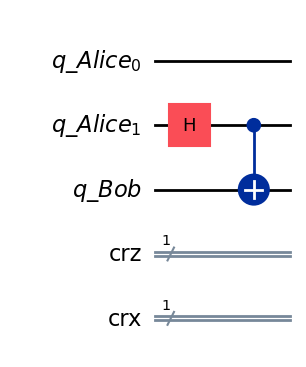

In [4]:
# Step 1: Charlie creates entangled state
create_bell_pair(teleportation_circuit, 1, 2)   # qubits 1 and 2 are entangled now
teleportation_circuit.draw(output="mpl", style="iqp")

####  State after step 1

After we entangle qubits $|q_1\rangle$ and $|q_2\rangle$, we obtain the state

\begin{align*}
|\psi_1\rangle & = (((H \otimes I) CNOT) \otimes I) |\psi\rangle \tag{definition} \\
& = (\frac{1}{\sqrt{2}}|00\rangle + \frac{1}{\sqrt{2}}|11\rangle) \otimes |\psi\rangle \tag{Bell state} \\
& = (\frac{1}{\sqrt{2}}|00\rangle + \frac{1}{\sqrt{2}}|11\rangle) \otimes (\alpha|0\rangle + \beta|1\rangle) \tag{definition} \\
& = \frac{1}{\sqrt{2}}(\alpha|000\rangle + \alpha|110\rangle + \beta|001\rangle + \beta|111\rangle) \tag{calculation} \,.
\end{align*}

In [5]:
alpha = 1/np.sqrt(3)
beta = np.sqrt(2/3)
psi = alpha*zero + beta*one
(zero ^ zero ^ psi).evolve(teleportation_circuit).draw("latex")

<IPython.core.display.Latex object>

### Step 2: Alice's computation

Alice applies

$$
(I \otimes I \otimes H)(I \otimes CNOT)
$$

to the result of step 1.

In [6]:
def alice_gates(qc, q, a):
    qc.cx(q, a)
    qc.h(q)

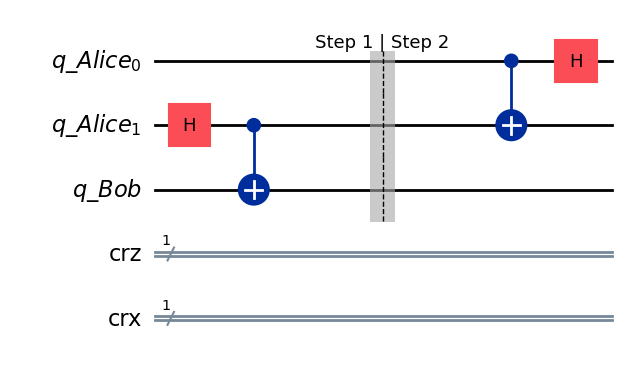

In [7]:
## Step 2
teleportation_circuit.barrier(label="Step 1 | Step 2") # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.draw(output="mpl", style="iqp")

#### State after step 2

After Alice performs here computation, we obtain the quantum state

\begin{align*}
|\psi_2\rangle & = (I \otimes I \otimes H)(I \otimes CNOT) |\psi_1\rangle \tag{step 2} \\
& = (I \otimes I \otimes H)(I \otimes CNOT)(\frac{1}{\sqrt{2}}(\alpha|000\rangle + \alpha|110\rangle + \beta|001\rangle + \beta|111\rangle) \tag{definition $\psi_1\rangle$} \\
& = (I \otimes I \otimes H)(\frac{1}{\sqrt{2}}(\alpha|000\rangle + \alpha|110\rangle + \beta|011\rangle + \beta|101\rangle) \tag{CNOT} \\
& = \frac{1}{2}\alpha(|000\rangle + |110\rangle + |001\rangle + |111\rangle) + \frac{1}{2}\beta(|010\rangle + |100\rangle - |011\rangle - |101\rangle) \tag{H} \\
& = \frac{1}{2}((\alpha|0\rangle + \beta|1\rangle)|00\rangle + (\alpha|1\rangle + \beta|0\rangle)|10\rangle + (\alpha|0\rangle - \beta|1\rangle)|01\rangle + (\alpha|1\rangle - \beta|0\rangle)|11\rangle)
\tag{factoring} \,.
\end{align*}

In [8]:
(zero ^ zero ^ psi).evolve(teleportation_circuit).draw('latex')

<IPython.core.display.Latex object>

In [9]:
# Save the circuit before measurement
U_steps_1_to_2 = Operator(teleportation_circuit)

### Step 3: Transmission

1. Alice measures qubit $0$ and qubit $1$, and sends them as classical bits to Bob.
2. Recall that qubit $1$ is entangled with qubit $2$, and that Bob has access to qubit $2$.

In [10]:
def measure_and_send(qc, a, b):
    qc.measure(a, 0)
    qc.measure(b, 1)

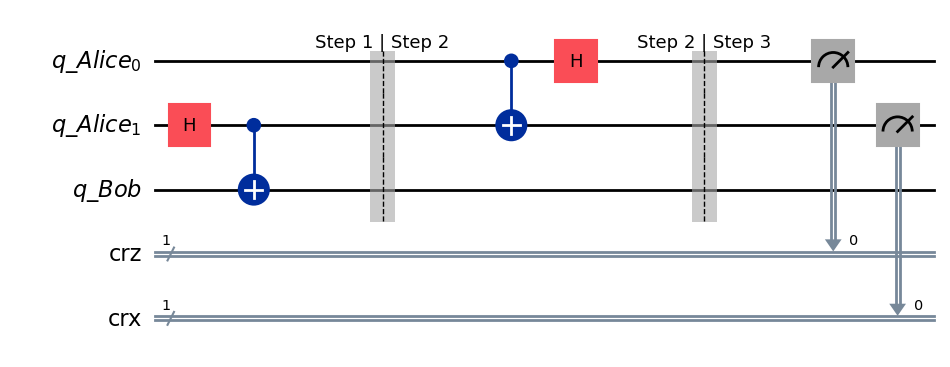

In [11]:
# Step 3: Transmission
teleportation_circuit.barrier(label="Step 2 | Step 3")
measure_and_send(teleportation_circuit, 0, 1)
teleportation_circuit.draw(output="mpl", style="iqp")

#### Effect on quantum state

As a reminder,

$$
|\psi_2\rangle = \frac{1}{2}((\alpha|0\rangle + \beta|1\rangle)|00\rangle + (\alpha|1\rangle + \beta|0\rangle)|10\rangle + (\alpha|0\rangle - \beta|1\rangle)|01\rangle + (\alpha|1\rangle - \beta|0\rangle)|11\rangle \,.
$$

After measurement, Alice will have
1. $|00\rangle$,
2. $|10\rangle$,
3. $|01\rangle$, and
4. $|11\rangle$ all with equal probability.

Bob will have
1. $(\alpha|0\rangle + \beta|1\rangle)$ if Alice measures $|00\rangle$,
2. $(\alpha|1\rangle + \beta|0\rangle)$ if Alice measures $|10\rangle$,
3. $(\alpha|0\rangle - \beta|1\rangle)$ if Alice measures $|01\rangle$, and
4. $(\alpha|1\rangle - \beta|0\rangle)$ if Alice measure $|11\rangle$.

We can use density matrices to check these results.

In [12]:
# The state before step 3
v = (zero ^ zero ^ psi).evolve(U_steps_1_to_2)
v.draw("latex")

<IPython.core.display.Latex object>

In [13]:
# The density matrix before step 3
rho = qi.DensityMatrix(v)
rho.draw("latex")

<IPython.core.display.Latex object>

In [14]:
# Checking that we do indeed have a pure state
np.trace(rho.data @ rho.data)

(0.9999999999999991+0j)

#### Recall partial measurement on density matrix

Let $\{ M_m \}_m$ be a set of **measurement** operators where $m$ refers to the outcome so that it satisfies

$$
\sum_m M_m^\dagger M_m = I \,.
$$

Then the probability of obtaining outcome $m$ after measuring is

$$
p(m) = tr(M_m^\dagger M_m \rho)
$$

and the state of the system after measurement is

$$
\frac{M_m \rho M_m^\dagger}{tr(M_m^\dagger M_m \rho)} \,.
$$

In [15]:
zzz = zero ^ zero ^ zero; zzo = zero ^ zero ^ one;
zoz = zero ^ one ^ zero; zoo = zero ^ one ^ one;
ozz = one ^ zero ^ zero; ozo = one ^ zero ^ one;
ooz = one ^ one ^ zero; ooo = one ^ one ^ one;

# Construct partial measurements
Pi00 = np.outer(zzz, zzz) + np.outer(ozz, ozz)
Pi01 = np.outer(zzo, zzo) + np.outer(ozo, ozo)
Pi10 = np.outer(zoz, zoz) + np.outer(ooz, ooz)
Pi11 = np.outer(zoo, zoo) + np.outer(ooo, ooo)
Pretty(Pi00 + Pi01 + Pi10 + Pi11)

<IPython.core.display.Latex object>

Checking the results when `00` is measured.

In [16]:
p_00, rho_00 = measure_outcome(rho, Pi00)
print(p_00)
Pretty(rho_00)

(0.2499999999999999+0j)


<IPython.core.display.Latex object>

In [17]:
bob_00 = alpha * zero + beta * one
np.allclose(rho_00, np.outer((bob_00 ^ zero ^ zero), (bob_00 ^ zero ^ zero)))

True

Checking the results when `01` is measured.

In [18]:
p_01, rho_01 = measure_outcome(rho, Pi01)
print(p_01)
Pretty(rho_01)

(0.2499999999999999+0j)


<IPython.core.display.Latex object>

In [19]:
bob_01 = alpha * zero - beta * one
np.allclose(rho_01, np.outer((bob_01 ^ zero ^ one), (bob_01 ^ zero ^ one)))

True

### Step 4: Bob's computation

Bob now needs to reconstruct Alice's qubit $|q_1\rangle$ in his qubit $|q_2\rangle$ using the two classical bits that Alice has provided. As a reminder, Bob at this point has
1. $(\alpha|0\rangle + \beta|1\rangle)$ if Alice measures $|00\rangle$,
2. $(\alpha|1\rangle + \beta|0\rangle)$ if Alice measures $|10\rangle$,
3. $(\alpha|0\rangle - \beta|1\rangle)$ if Alice measures $|01\rangle$, and
4. $(\alpha|1\rangle - \beta|0\rangle)$ if Alice measure $|11\rangle$.

The trick to reconstruct $|\psi\rangle = \alpha|0\rangle + \beta|1\rangle$ is to realize that we just need to use the cloassical bits, i.e., the results of Alice's measurement, to correct the phases of our quantum state. In particular,
1. no correction if $|00\rangle$ is received,
2. a flip (X) if $|10\rangle$ is received,
3. a phase flip (Z) if $|01\rangle$ is received, and
4. a flip (X) and phase flip (Z) if $|11\rangle$ is received.

We give this circuit now.

In [20]:
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'

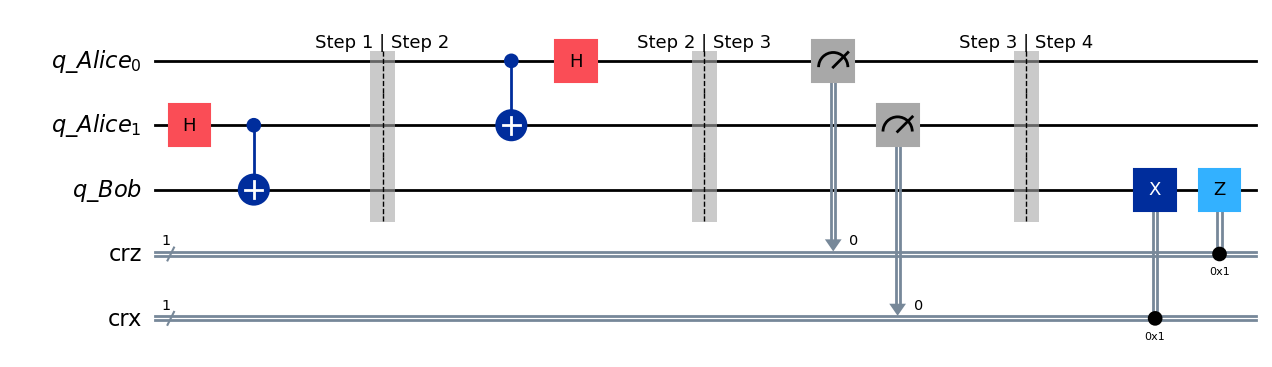

In [21]:
## Step 4: Bob's computation
teleportation_circuit.barrier(label="Step 3 | Step 4") # Use barrier to separate steps
bob_gates(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw(output="mpl", style="iqp")

#### State after step 4.

After decoding, Bob has
1. $(\alpha|0\rangle + \beta|1\rangle)$ becomes $(\alpha|0\rangle + \beta|1\rangle)$,
2. $(\alpha|1\rangle + \beta|0\rangle)$ becomes $X(\alpha|1\rangle + \beta|0\rangle) = \alpha|0\rangle + \beta|1\rangle$,
3. $(\alpha|0\rangle - \beta|1\rangle)$ becomes $Z(\alpha|0\rangle - \beta|1\rangle) = \alpha|0\rangle + \beta|1\rangle$, and
4. $(\alpha|1\rangle - \beta|0\rangle)$ becomes $ZX(\alpha|1\rangle - \beta|0\rangle) = \alpha|0\rangle + \beta|1\rangle$.

Thus Bob has indeed received the qubit $|\psi\rangle$ from Alice. Moreover, Alice's knowledge of $|\psi\rangle$ has been destroyed.

### Putting it together

We gather all the pieces together into a single function to enable more experimentation.

In [22]:
def quantum_teleportation(psi: Statevector) -> QuantumCircuit:
    # Create circuit
    qr = QuantumRegister(3, name="q")
    crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
    qc_tele = QuantumCircuit(qr, crz, crx)
    
    # Initialize qubit 0 to the message that Alice wants to send
    qc_tele.initialize(psi, 0)
    
    # Step 1: Third party creates entangled state
    create_bell_pair(qc_tele, 1, 2)
    qc_tele.barrier(label="Step 1 | Step 2")
    
    # Step 2: Alice's computation
    alice_gates(qc_tele, 0, 1)
    qc_tele.barrier(label="Step 2 | Step 3")

    # Step 3: Transmit
    measure_and_send(qc_tele, 0 ,1)
    qc_tele.barrier(label="Step 3 | Step 4")
    
    # Step 4: Bob's computation
    bob_gates(qc_tele, 2, crz, crx)
    
    return qc_tele

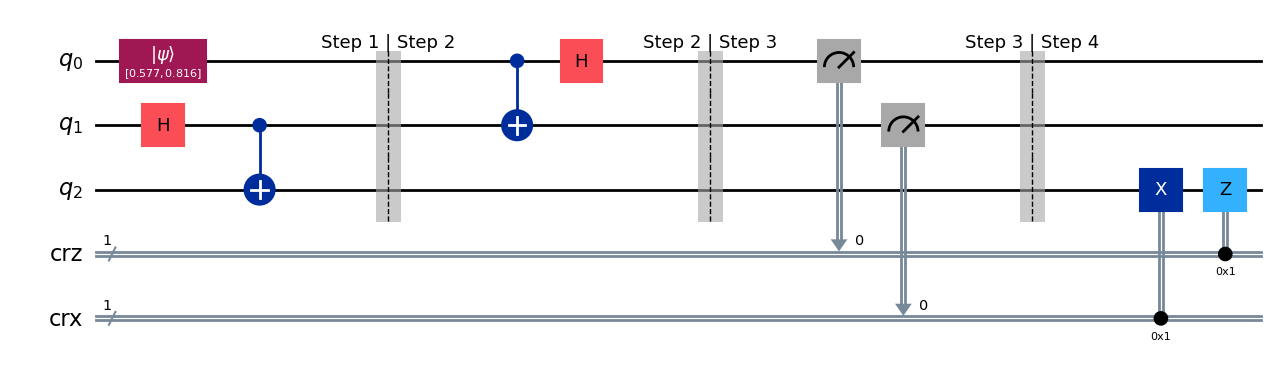

In [23]:
alpha = 1/np.sqrt(3); beta = np.sqrt(2/3)
psi = alpha*zero + beta*one
qc_tele = quantum_teleportation(psi)
qc_tele.draw(output="mpl", style="iqp")

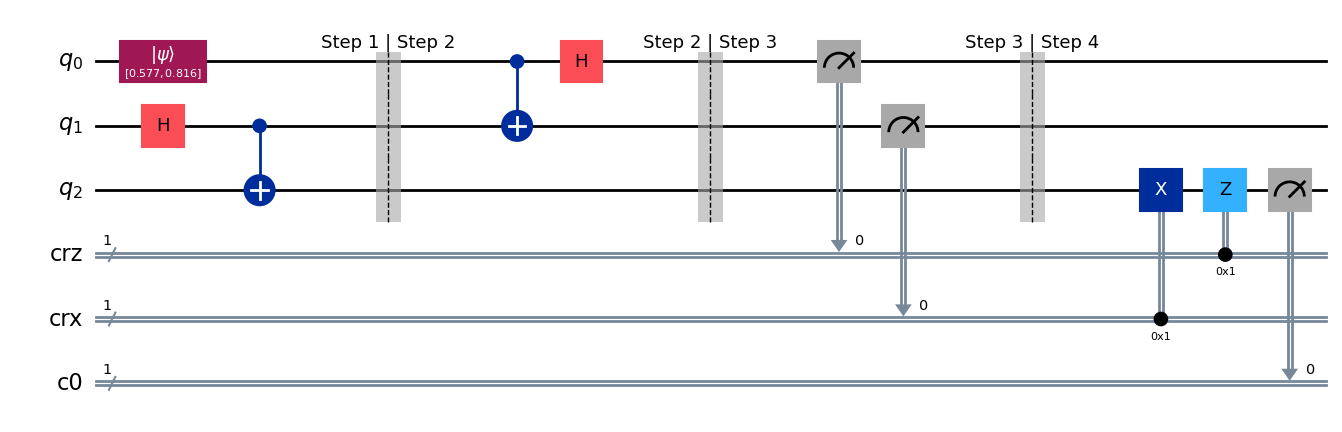

In [24]:
cr_result = ClassicalRegister(1)
qc_tele.add_register(cr_result)
qc_tele.measure(2,2)
qc_tele.draw(output="mpl", style="iqp")

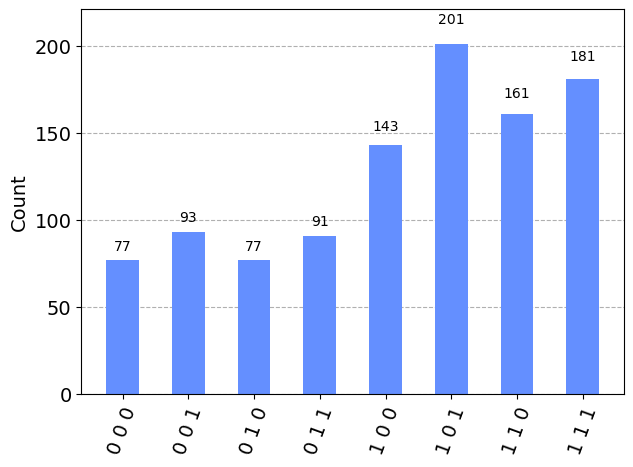

In [25]:
result = sim.run(qc_tele).result()
counts = result.get_counts(qc_tele)
plot_histogram(counts)

## Summary

Quantum teleportation is a protocol where one party can send 1 qubit to another party using 1 entangled qubit and 2 classical bits. Importantly, no cloning is not violated.